In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('ss_curves.csv')

In [11]:
def preprocess(df):
    stress = np.array([df[col] for col in df.columns if "stress" in col])
    strain = np.array([df[col] for col in df.columns if "strain" in col])
    labels = ["Experimental"] + [f"Simulated {i}" for i in range(1, len(stress)+1)]

    # Cut the excess values above and below the experimental values.
    exp_strain = strain[0]
    x_min, x_max = 0.002, exp_strain.max()
    prune = np.logical_and(strain[1] > x_min, strain[1] < x_max)  # Indices to prune simulated curves by
    sim_strain = strain[1:][:, prune]
    sim_stress = stress[1:][:, prune]
    # Linear Interpolation
    f = interp1d(exp_strain, stress[0])
    exp_stress = f(sim_strain[0]) # The target curve
    return exp_stress, sim_stress, sim_strain[0], labels, sim_strain

def plot(stress, strain, label):
    plt.figure(figsize=(10,10))
    for x,y,label in zip(strain,stress,label):
        plt.plot(x, y, label=label,linewidth=3)
    plt.xlim([0,0.1])
    plt.ylim([0,1100])
    plt.vlines(strain[0].max(), 0, 1100, linestyle='dotted')
    plt.title("Simulated vs. Experimental Stain-Stress Curves")
    plt.xlabel("Strain")
    plt.ylabel("Stress")
    plt.legend(fontsize='xx-large')
    plt.show()

In [4]:
exp_stress, sim_stresses, strain, labels, sim_strains = preprocess(df)

In [5]:
exp_stress.shape

(344,)

In [6]:
def D1(exp_stress, sim_stress): 
    uh = np.sum(np.square(exp_stress-sim_stress)/len(strain))
    return uh

# Testing on every index of sigma_hats
resD1 = []
for stress in sim_stresses:
    print(stress.shape)
    resD1.append(D1(exp_stress, stress))
resD1

(344,)
(344,)
(344,)
(344,)
(344,)
(344,)
(344,)


[44.67803046696963,
 66.40368492943377,
 50.54591199344124,
 27.953837569801145,
 17.52639224600526,
 19.263575798501584,
 33.165388145386686]

### Loss Functions

In [7]:
def rmse(exp_stress, sim_stress): 
    return np.sqrt(mean_squared_error(exp_stress, sim_stress))

def D1(exp_stress, sim_stress): # Proportional to MSE. But no easy comparison between different exp_stresses.
    return np.sqrt(np.sum(np.square(sim_stress - exp_stress)) / np.sum(np.square(exp_stress)))

def D1_local(exp_stress, sim_stress): # L2 local loss
    return np.square(exp_stress-sim_stress)

def D2(exp_stress, sim_stress):
    return np.abs(((sim_stress[-1] - sim_stress[0]) - (exp_stress[-1] - exp_stress[0] )) / (exp_stress[-1] - exp_stress[0]))

def combined_loss(exp_stress, sim_stress, w1, w2): #wL2 and wD2 are the weights chosen for each type of objective funtion
    return w2*(D1(exp_stress, sim_stress)) + w2*(D2(exp_stress, sim_stress))

In [8]:
rmse_loss = [] 
D1_loss = []
D2_loss = []
combined_losses = []

for sim_stress in sim_stresses:
    rmse_loss.append(rmse(exp_stress, sim_stress))
    D1_loss.append(D1(exp_stress,sim_stress))
    D2_loss.append(D2(exp_stress,sim_stress))
    combined_losses.append(combined_loss(exp_stress,sim_stress,0.9,0.1))

,d1,d2,combined
0,0.006685,0.122767,0.012945
1,0.008150,0.044423,0.005257
2,0.007110,0.052257,0.005937
3,0.005288,0.067926,0.007321
4,0.004187,0.083595,0.008778
5,0.004389,0.099264,0.010365
6,0.005760,0.114933,0.012069


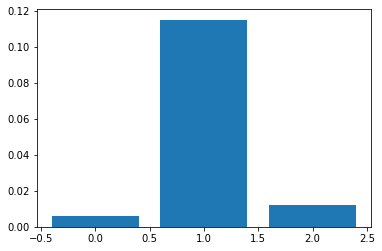

In [9]:
losses = pd.DataFrame(np.array([ D1_loss, D2_loss, combined_losses]).T, columns = [ 'd1', 'd2', 'combined'])
plt.bar(x=range(3), height=losses.iloc[6])
losses

# D1 Loss

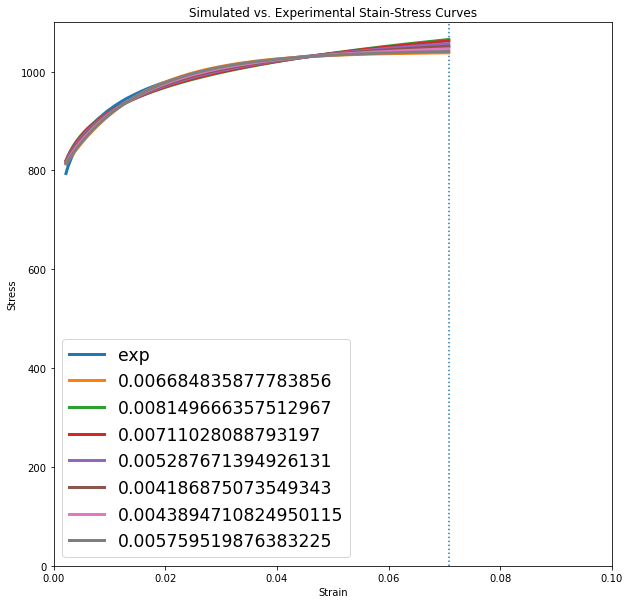

In [12]:
plot(np.vstack((exp_stress,sim_stresses)), np.tile(strain,(8,1)), ['exp'] + D1_loss)

### D2 Loss

In [ ]:
plot(np.vstack((exp_stress,sim_stresses)), np.tile(strain,(8,1)), ['exp'] + D2_loss)

# RMSE

In [ ]:
plot(np.vstack((exp_stress,sim_stresses)), np.tile(strain,(8,1)), ['exp'] + rmse_loss)

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0,1] = plt.bar(x=range(1,8), height=D2_loss)

### Local RMSE Loss Visualized

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(strain, exp_stress, linewidth=5, label="Experimental Strain-Stress")
plt.plot(strain, sim_stresses[1],  linewidth=5, label="Simulated Strain-Stress")
plt.fill_between(strain, exp_stress, sim_stresses[1], color='grey', alpha=0.7)
plt.bar(strain, np.sqrt(D1_local(exp_stress, sim_stresses[1])), width=strain[1]-strain[0], align='edge', bottom=800, alpha=0.6, label="RMSE (not to scale)"),
plt.xlabel("Strain",fontsize='x-large')
plt.ylabel("Stress (MPa)",fontsize='x-large')
plt.legend(fontsize='xx-large')

In [ ]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

w1 = 0.7
w2 = 1e-6
w3 = 0.3
w4 = 1e-5
width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
L1 = np.array(resD1)*w1
L2 = np.array(resD2)*w2
L3 = np.array(resD3)*w3
L4 = np.array(resD4)*w4

ax.bar(labels, L1, width, label='D1')
ax.bar(labels, L2, width, bottom=L1 , label='D2')
ax.bar(labels, L3, width, bottom=L1+L2, label='D3')
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4')

ax.set_ylabel('Scores')
ax.set_title('Objectice Function Results')
ax.legend()

plt.show()

In [ ]:
d1 = np.diff(exp_stress)/np.diff(strain)

In [ ]:
plt.plot(strain[1:], d1)